In [1]:
import numpy as np

from tqdm import tqdm
from matplotlib import pyplot as plt

import torch, numpy as np
import torch.nn.functional as F
import torch.nn as nn
import torch.utils.data as Data
import matplotlib.pyplot as plt


SEED = 4200
torch.manual_seed(SEED)
np.random.seed(SEED)

torch.set_default_dtype(torch.float64)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Matrix factorization through vanilla SCA

In [4]:
def MF_SCA(A, L, lambda_v = 0.1, lambda_w = 0.1, eta_v = 0.9, eta_w = 0.9, max_iter = 200):
    m = A.shape[0]
    n = A.shape[1]

    V = np.ones((m,L)) 
    W = np.ones((L,n)) 

    # Let's also keep the Frobenius distances between the matrix A and its reconstruction VW
    
    D = np.zeros(max_iter)
    D[0] = np.linalg.norm(A - V @ W, ord = 'fro')
    
    for _ in tqdm(range(1, max_iter)):   

        # Local optimization step
        V_hat = A @ W.T @ np.linalg.inv(W @ W.T + lambda_v * np.eye(L))
        W_hat = np.linalg.inv(V.T @ V + lambda_w * np.eye(L)) @ V.T @ A   
        
        '''
        V_hat = (1 - lambda_v/np.max([lambda_v, np.linalg.norm(A @ np.linalg.pinv(W))])) @ A @ np.linalg.pinv(W)
        W_hat = (1 - lambda_w/np.max([lambda_v, np.linalg.norm(np.linalg.pinv(V) @ A)])) @ np.linalg.pinv(V) @ A
        '''

        # Global smoothing step
        V = V + eta_v * (V_hat - V)
        W = W + eta_w * (W_hat - W)

        # Decreasing stepsize
        eta_v = eta_v * 0.99
        eta_w = eta_w * 0.99

        # Storing the reconstruction error
        D[_] = np.linalg.norm(A - V @ W, ord = 'fro')

    return (V,W), D

In [5]:
A = np.random.normal(size = (1500,2000))
A /= np.linalg.norm(A, axis = 0)
(V,W), D = MF_SCA(A,100)

100%|██████████| 199/199 [00:09<00:00, 21.67it/s]


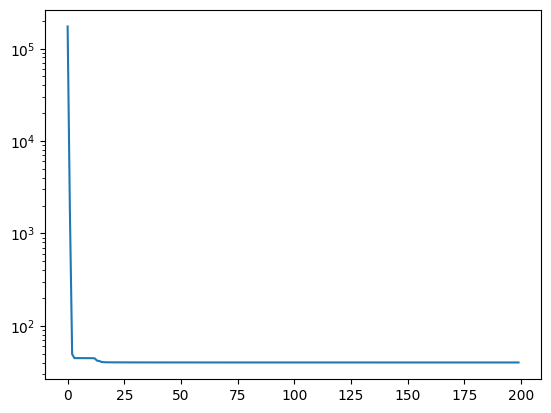

In [6]:
plt.plot(D)
plt.yscale('log')

In [7]:
np.linalg.norm(V @ W - A, ord='fro')

40.10453107897018

### Neural Building Blocks design - Deep Matrix Factorization

In [8]:
# Model for optimizing wrt V 

M = 400
N = 200
L = 15

A = torch.randn(M, N)
V = torch.randn(M, L)
W = torch.randn(L, N)

In [9]:
class ModuleV(nn.Module):
    def __init__(self, M, L, N, lambda_, t = 100):
        super().__init__()
        self.M = M
        self.L = L
        self.N = N
        
        self.t = t
        self.lambda_ = lambda_
        self.reset()
        self.optimizer = torch.optim.Adam(params=self.parameters(), lr=1, weight_decay = 3e-3)

    def forward(self, W):
        return self.V @ W
    
    def emit(self):
        return self.V

    def loss(self, A, W):
        return torch.linalg.norm(A - self.forward(W), 'fro') + self.lambda_ * torch.linalg.norm(self.forward(W), 'fro')

    def step(self, A, W):
        self.optimizer.zero_grad()
        loss_ = self.loss(A, W)
        loss_.backward(retain_graph=True)
        torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=1.0)
        self.optimizer.step()
    
    def learn(self, A, W):
        for _ in range(self.t):
            self.step(A, W)

    def reset(self):
        self.V = nn.Parameter(torch.ones(self.M, self.L), requires_grad=True)


In [10]:
class ModuleW(nn.Module):
    def __init__(self, M, L, N, lambda_, t = 100):
        super().__init__()
        self.M = M
        self.L = L
        self.N = N
        
        self.t = t
        self.lambda_ = lambda_
        
        self.reset()
        self.optimizer = torch.optim.Adam(params=self.parameters(), lr=1, weight_decay = 3e-3)

    def forward(self, V):
        return V @ self.W
    
    def emit(self):
        return self.W
    
    def loss(self, A, V):
        return torch.linalg.norm(A - self.forward(V), 'fro') + self.lambda_ * torch.linalg.norm(self.forward(V), 'fro')
    
    def step(self, A, V):
        self.optimizer.zero_grad()
        loss_ = self.loss(A, V)
        loss_.backward(retain_graph=True)
        torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=1.0)
        self.optimizer.step()
    
    def learn(self, A, V):
        for _ in range(self.t):
            self.step(A, V)
    
    def reset(self):
        self.W = nn.Parameter(torch.ones(self.L, self.N), requires_grad=True)


In [11]:
class DeepMatrixFactorization(nn.Module):
    def __init__(self, M, L, N, lambda_ = 0.5, gamma = 0.99, T = 50, t = 100):

        self.M = M
        self.L = L
        self.N = N

        self.T = T
        self.t = t

        self.lambda_ = lambda_
        self.gamma = gamma

        self.blocks = []
        self.gammas = []

        for t in range(self.T):
            self.blocks.append({
                'Block V': ModuleV(self.M, self.L, self.N, self.lambda_, self.t),
                'Block W': ModuleW(self.M, self.L, self.N, self.lambda_, self.t)
            })

            self.gammas.append(self.gamma * (0.99 ** self.t))
        
        self.losses = []

    def inference(self, A): 
        
        V = torch.ones(self.M, self.L) 
        W = torch.ones(self.L, self.N) 

        self.losses.append((torch.linalg.norm(A - V @ W, 'fro')).detach().numpy())
        
        for t in tqdm(range(self.T)):
            
            self.blocks[t]['Block V'].learn(A, W)
            self.blocks[t]['Block W'].learn(A, V)

            V = V + self.gammas[t]*(self.blocks[t]['Block V'].emit() - V)
            W = W + self.gammas[t]*(self.blocks[t]['Block W'].emit() - W)

            self.blocks[t]['Block V'].reset()
            self.blocks[t]['Block W'].reset()

            self.losses.append((torch.linalg.norm(A - V @ W, 'fro')).detach().numpy())
        
        return V, W


In [16]:
model = DeepMatrixFactorization(M, L, N, lambda_ = 0.01)

In [17]:
V_, W_ = model.inference(A)

100%|██████████| 50/50 [00:35<00:00,  1.39it/s]


In [18]:
_, D2 = MF_SCA(A.detach().numpy(),L,max_iter=51)

100%|██████████| 50/50 [00:00<00:00, 543.52it/s]


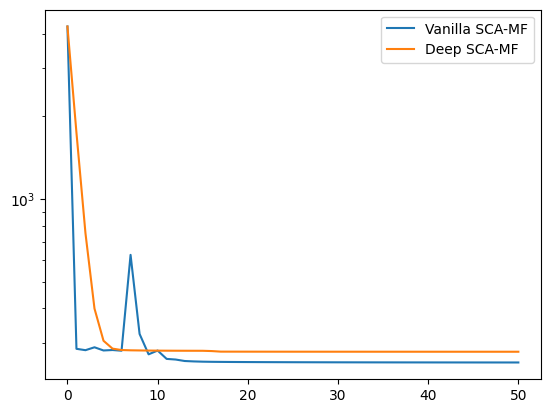

In [19]:
plt.plot(D2, label='Vanilla SCA-MF')
plt.plot(model.losses, label= 'Deep SCA-MF')
plt.yscale('log')
plt.legend()

__________

# Redesigning unrolled matrix factorization 

In [2]:
def NNMF_SCA(A, L, lambda_v = 0.1, lambda_w = 0.1, eta_v = 0.9, eta_w = 0.9, max_iter = 200):
    m = A.shape[0]
    n = A.shape[1]

    V = np.ones((m,L)) 
    W = np.ones((L,n)) 

    # Let's also keep the Frobenius distances between the matrix A and its reconstruction VW
    
    D = np.zeros(max_iter)
    D[0] = np.linalg.norm(A - V @ W, ord = 'fro')
    
    for _ in tqdm(range(1, max_iter)):   

        # Local optimization step
        V_hat = A @ W.T @ np.linalg.inv(W @ W.T + lambda_v * np.eye(L))
        V_hat = V_hat * (V_hat >= 0)

        W_hat = np.linalg.inv(V.T @ V + lambda_w * np.eye(L)) @ V.T @ A   
        W_hat = W_hat * (W_hat >= 0)
        
        '''
        V_hat = (1 - lambda_v/np.max([lambda_v, np.linalg.norm(A @ np.linalg.pinv(W))])) @ A @ np.linalg.pinv(W)
        W_hat = (1 - lambda_w/np.max([lambda_v, np.linalg.norm(np.linalg.pinv(V) @ A)])) @ np.linalg.pinv(V) @ A
        '''

        # Global smoothing step
        V = V + eta_v * (V_hat - V)
        W = W + eta_w * (W_hat - W)

        # Decreasing stepsize
        eta_v = eta_v * 0.99
        eta_w = eta_w * 0.99

        # Storing the reconstruction error
        D[_] = np.linalg.norm(A - V @ W, ord = 'fro')

    return (V,W), D

In [4]:
A = np.random.normal(size = (150,2000))
A /= np.linalg.norm(A, axis = 0)
(V,W), D = NNMF_SCA(A,100)

100%|██████████| 199/199 [00:10<00:00, 18.75it/s]


In [5]:
V

array([[7.43060054e-02, 8.33793770e-02, 9.43949532e-40, ...,
        5.56026643e-44, 7.82224012e-31, 6.05779599e-41],
       [8.28563655e-46, 5.46794299e-41, 1.46291391e-02, ...,
        1.16418617e-02, 3.46084108e-02, 8.50891223e-43],
       [2.45466446e-50, 6.87197300e-39, 9.88039089e-45, ...,
        1.87653423e-03, 4.85521036e-02, 2.49842715e-02],
       ...,
       [7.40223440e-45, 5.56272073e-41, 1.27448578e-39, ...,
        6.18099800e-02, 9.23763086e-41, 1.19760809e-39],
       [1.86687061e-02, 2.85847439e-42, 2.25836603e-41, ...,
        1.31122702e-01, 2.12062711e-45, 1.00562935e-44],
       [4.50896250e-45, 2.81884250e-43, 5.62147543e-02, ...,
        2.38149702e-44, 2.20721793e-44, 2.95720170e-03]])

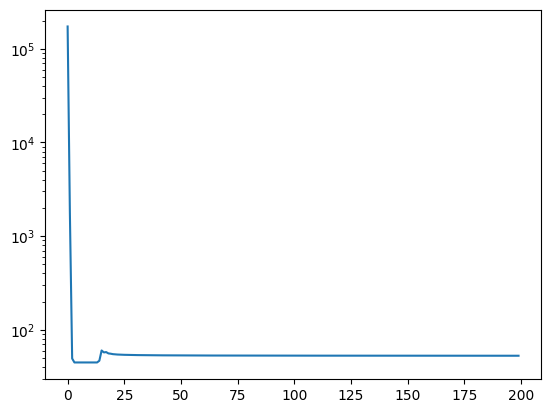

In [6]:
plt.plot(D)
plt.yscale('log')

In [3]:
class DNMF(nn.Module):
    def __init__(self, M, N, L, T = 10, gamma = 0.99):
        super(DNMF, self).__init__()

        # Matrix dimensions and latent factors
        self.M = M
        self.N = N
        self.L = L

        # Number of iterations
        self.T = T

        # Learnable parameters
        '''
        self.hV = nn.Parameter(torch.randn(L),requires_grad=True)
        self.hW = nn.Parameter(torch.randn(L),requires_grad=True)
        '''
        
        self.tauV = nn.Parameter(torch.ones(1),requires_grad=True)
        self.tauW = nn.Parameter(torch.ones(1),requires_grad=True)

        # Coefficient for convex combination
        self.gamma = gamma

        # Loss tracker
        self.loss = []
        
    def forward(self, A, loss_track = False):

        # Initialize V and W with the batch size in the first dimension
        V = torch.ones(A.shape[0], self.M, self.L)
        W = torch.ones(A.shape[0], self.L, self.N)

        for _ in range(self.T):

            # Compute V and W using batched matrix multiplication
            V = self.gamma * V + (1 - self.gamma) * nn.functional.relu(A @ W.transpose(1, 2) / self.tauV)
            W = self.gamma * W + (1 - self.gamma) * nn.functional.relu(V.transpose(1, 2) @ A / self.tauW)

            # Update gamma
            self.gamma *= 0.99

            if loss_track:
                self.loss.append(torch.norm(A - torch.bmm(V, W), p='fro')/A.shape[0])

        return V, W
    
    '''
    def forward(self, A):

        # Initialize V and W with the batch size in the first dimension
        V = torch.ones(A.shape[0], self.M, self.L)
        W = torch.ones(A.shape[0], self.L, self.N)

        for _ in range(self.T):
            
            HV = torch.outer(self.hV, self.hV) + self.tauV * torch.eye(self.L)
            HW = torch.outer(self.hW, self.hW) + self.tauW * torch.eye(self.L)

            # Compute V and W using batched matrix multiplication
            V = (1 - self.gamma) * V + self.gamma * nn.functional.relu((A @ W.transpose(1, 2) @ HV[None, :, :]))
            W = (1 - self.gamma) * W + self.gamma * nn.functional.relu((HW[None, :, :] @ V.transpose(1, 2) @ A))

            # Update gamma
            self.gamma *= 0.99

        return V, W
    '''

In [4]:
class MatrixDataset():
    def __init__(self, M, N, size = 1000, batch_size = 256):
        
        self.M = M          # Number of samples in the original signal
        self.N = N          # Number of samples through the linear transformation

        self.size = size    # Size of the dataset
        self.batch_size = batch_size

        # Preallocation
        self.A = torch.zeros(self.size,self.M,self.N)

        # Generating the dataset
        self.set_data()


    def set_matrix(self, i):

        # Generating random sparsity in the canonic basis of the original signal
        A = torch.randn(self.M, self.N)
        A /= torch.linalg.norm(A, axis = 0)
        self.A[i,:,:] = A


    def set_data(self):
        for i in range(self.size):
            self.set_matrix(i)
    
    
    def set_loader(self):
        return Data.DataLoader(dataset = Data.TensorDataset(self.A),
                               batch_size = self.batch_size,
                               shuffle = True)

In [19]:
# Dimensions for the matrices
m_ = 150
n_ = 200

# Building a training set and a test set 
train_set = MatrixDataset(m_, n_, size = 800).set_loader()
test_set = MatrixDataset(m_, n_, size = 200).set_loader()

In [20]:
def train(model, train_loader, valid_loader, num_epochs=50):

    # Initialization
    optimizer = torch.optim.SGD(
        model.parameters(),
        lr=5e-01,
        momentum=0.9,
        weight_decay=0,
    )
    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer, step_size=50, gamma=0.1
    )

    loss_train = np.zeros((num_epochs,))
    loss_test = np.zeros((num_epochs,))
    # Main loop

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for A in enumerate(train_loader):
            V, W = model.forward(A[1][0])
            loss = F.mse_loss(torch.bmm(V,W), A[1][0], reduction="sum")
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            model.zero_grad()
            train_loss += loss.data.item()
        loss_train[epoch] = train_loss / len(train_loader.dataset)
        scheduler.step()

        # validation
        model.eval()
        test_loss = 0
        for A in enumerate(valid_loader):
            V, W = model.forward(A[1][0])
            test_loss += F.mse_loss(torch.bmm(V,W), A[1][0], reduction="sum").data.item()
        loss_test[epoch] = test_loss / len(valid_loader.dataset)
        
        # Print
        if epoch % 10 == 0:
            print(
                "Epoch %d, Train loss %.8f, Validation loss %.8f"
                % (epoch, loss_train[epoch], loss_test[epoch])
            )

    return loss_test

In [21]:
model = DNMF(m_, n_, 20)

In [22]:
model.gamma

0.99

In [25]:
[p for p in list(model.parameters()) if p.is_leaf]

[Parameter containing:
 tensor([3.2337], requires_grad=True),
 Parameter containing:
 tensor([3.1751], requires_grad=True)]

In [24]:
train(model, train_set, test_set)

Epoch 0, Train loss 2029617.68691733, Validation loss 200.55454620
Epoch 10, Train loss 200.00000000, Validation loss 200.00000000
Epoch 20, Train loss 200.00000000, Validation loss 200.00000000
Epoch 30, Train loss 200.00000000, Validation loss 200.00000000
Epoch 40, Train loss 200.00000000, Validation loss 200.00000000


array([200.5545462 , 199.99759631, 199.99998781, 199.99999974,
       199.99999998, 200.        , 200.        , 200.        ,
       200.        , 200.        , 200.        , 200.        ,
       200.        , 200.        , 200.        , 200.        ,
       200.        , 200.        , 200.        , 200.        ,
       200.        , 200.        , 200.        , 200.        ,
       200.        , 200.        , 200.        , 200.        ,
       200.        , 200.        , 200.        , 200.        ,
       200.        , 200.        , 200.        , 200.        ,
       200.        , 200.        , 200.        , 200.        ,
       200.        , 200.        , 200.        , 200.        ,
       200.        , 200.        , 200.        , 200.        ,
       200.        , 200.        ])

In [26]:
import torch.nn.functional as F

def NNMF_SCA_BATCH(A, L, lambda_v=0.1, lambda_w=0.1, eta_v=0.9, eta_w=0.9, max_iter=40):
    device = A.device  # Ensure operations are performed on the same device as input
    batch_size, m, n = A.shape

    V = torch.ones((batch_size, m, L), device=device)
    W = torch.ones((batch_size, L, n), device=device)

    # Frobenius distances for each iteration
    D = torch.zeros(max_iter, device=device)
    D[0] = torch.norm(A - torch.bmm(V, W), p='fro')

    for it in tqdm(range(1, max_iter)):
        # Local optimization step
        WWT_inv = torch.linalg.inv(torch.bmm(W, W.transpose(1, 2)) + lambda_v * torch.eye(L, device=device).unsqueeze(0))
        V_hat = torch.bmm(torch.bmm(A, W.transpose(1, 2)), WWT_inv)
        V_hat = torch.relu(V_hat)  # Ensure non-negativity

        VTV_inv = torch.linalg.inv(torch.bmm(V.transpose(1, 2), V) + lambda_w * torch.eye(L, device=device).unsqueeze(0))
        W_hat = torch.bmm(VTV_inv, torch.bmm(V.transpose(1, 2), A))
        W_hat = torch.relu(W_hat)  # Ensure non-negativity

        # Global smoothing step
        V = V + eta_v * (V_hat - V)
        W = W + eta_w * (W_hat - W)

        # Decreasing stepsize
        eta_v *= 0.99
        eta_w *= 0.99

        # Storing the reconstruction error
        D[it] = torch.norm(A - torch.bmm(V, W), p='fro')/A.shape[0]

    return (V, W), D

In [27]:
model.gamma = 0.99 

In [28]:
A = torch.randn(256, 150, 200) 
(V, W), D = NNMF_SCA_BATCH(A, L=20)

V,W = model.forward(A, True)

100%|██████████| 39/39 [00:01<00:00, 20.64it/s]


In [29]:
D

tensor([5.5495e+04, 1.1048e+01, 1.0815e+01, 1.0923e+01, 1.0786e+01, 1.0792e+01,
        1.0773e+01, 1.0900e+01, 7.6325e+01, 1.1324e+01, 1.8210e+01, 1.1105e+01,
        1.3077e+01, 1.1107e+01, 1.1749e+01, 1.1169e+01, 1.1351e+01, 1.1175e+01,
        1.1209e+01, 1.1151e+01, 1.1147e+01, 1.1123e+01, 1.1112e+01, 1.1098e+01,
        1.1087e+01, 1.1076e+01, 1.1067e+01, 1.1059e+01, 1.1051e+01, 1.1045e+01,
        1.1038e+01, 1.1032e+01, 1.1027e+01, 1.1022e+01, 1.1017e+01, 1.1013e+01,
        1.1008e+01, 1.1004e+01, 1.1001e+01, 1.0997e+01])

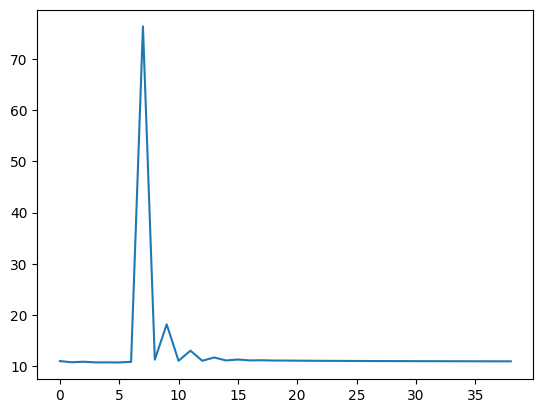

In [30]:
plt.plot(D[1:])

In [31]:
model.loss

[tensor(219.7284, grad_fn=<DivBackward0>),
 tensor(227.1172, grad_fn=<DivBackward0>),
 tensor(242.4082, grad_fn=<DivBackward0>),
 tensor(272.3513, grad_fn=<DivBackward0>),
 tensor(330.2046, grad_fn=<DivBackward0>),
 tensor(443.6855, grad_fn=<DivBackward0>),
 tensor(675.4628, grad_fn=<DivBackward0>),
 tensor(1179.6810, grad_fn=<DivBackward0>),
 tensor(2368.1953, grad_fn=<DivBackward0>),
 tensor(5437.2598, grad_fn=<DivBackward0>)]

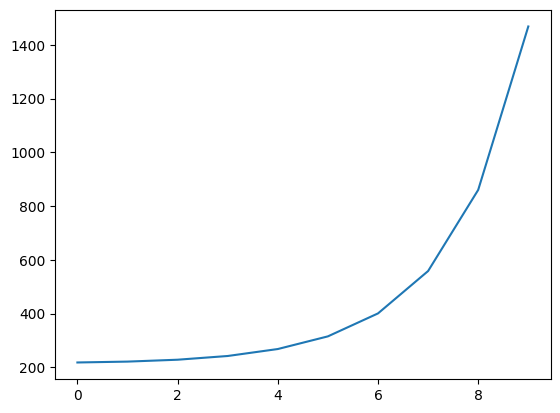

In [16]:
plt.plot([L.detach().numpy() for L in model.loss])